In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.models import Sequential, load_model
from keras.optimizers import adam
from sklearn.metrics import roc_auc_score 

In [20]:
df_train = pd.read_csv('train_splitted.csv')
df_valid = pd.read_csv('valid_splitted.csv')

X_train = df_train.drop(columns=['ID_code', 'target']).values
X_valid = df_valid.drop(columns=['ID_code', 'target']).values

y_train = df_train['target'].values
y_valid = df_valid['target'].values

In [21]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(160000, 200) (160000,)
(40000, 200) (40000,)


In [22]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        x1 = x[y==1].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[:,c][ids]
        xs.append(x1)

    for i in range(t//2):
        x1 = x[y==0].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[:,c][ids]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [23]:
# CPU times: user 13.3 s, sys: 8.3 s, total: 21.6 s
# Wall time: 18 s
# CPU times: user 3.1 s, sys: 405 ms, total: 3.51 s
# Wall time: 1.03 s
%time X_train_aug, y_train_aug = augment(X_train, y_train)

CPU times: user 3.89 s, sys: 424 ms, total: 4.32 s
Wall time: 1.18 s


In [24]:
X_train_aug_sqr = X_train_aug
X_valid_sqr = X_valid

In [25]:
# X_train_aug_sqr = np.append(X_train_aug, X_train_aug**2, axis=1)
# X_train_aug_sqr = np.append(X_train_aug_sqr, X_train_aug**3, axis=1)
# X_valid_sqr = np.append(X_valid, X_valid**2, axis=1)
# X_valid_sqr = np.append(X_valid_sqr, X_valid**3, axis=1)

In [26]:
X_train_aug_sqr.shape, X_valid_sqr.shape

((336046, 200), (40000, 200))

In [27]:
y_train_aug_cat = np.array([y_train_aug, 1-y_train_aug]).T
y_valid_cat = np.array([y_valid, 1-y_valid]).T

# Model solo con train

In [28]:
from keras.regularizers import l1

In [29]:
#l1_reg = l1(l=0.0001)

In [30]:
model = Sequential()
p_do = 0.5
model.add(Dense(200, input_shape=(X_train_aug_sqr.shape[1],))) #kernel_regularizer=l1_reg,
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p_do))

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p_do))

# model.add(Dense(200))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(p_do))

model.add(Dense(2, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
activation_3 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
activation_4 (Activation)    (None, 200)               0         
__________

In [29]:
# from clr import LRFinder

# model.compile('SGD', loss='categorical_crossentropy', metrics=['accuracy'])
# batch_size = 256
# lr_callback = LRFinder(len(X_train_aug), batch_size,
#                        1e-6, 1,
#                        # validation_data=(X_val, Y_val),
#                        lr_scale='exp', save_dir='data')

# # Ensure that number of epochs = 1 when calling fit()
# model.fit(X_train_aug, y_train_aug_cat, epochs=1, batch_size=batch_size, callbacks=[lr_callback])

In [30]:
# lr_callback.plot_schedule()

In [37]:
# from clr import OneCycleLR

# lr_manager = OneCycleLR(1e-2)
                        
# model.fit(X_train_aug, y_train_aug_cat, 
#           epochs=10, 
#           batch_size=batch_size, 
#           validation_data=(X_test, y_test_cat), 
#           callbacks=[lr_manager])

In [38]:
from keras.callbacks import ModelCheckpoint

In [39]:
checkpoint = ModelCheckpoint('best.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [40]:
batch_size = 256
optimizer = adam(lr=1e-4)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.fit(X_train_aug_sqr, y_train_aug_cat, 
          batch_size=batch_size, 
          epochs=50, 
          validation_data=(X_valid_sqr, y_valid_cat), 
          callbacks = [checkpoint],
          verbose=1) 
          #class_weight=class_weight_keras)

Train on 336046 samples, validate on 40000 samples
Epoch 1/50
336046/336046 [==============================] - 4s 13us/step - loss: 0.3966 - acc: 0.8483 - val_loss: 0.2828 - val_acc: 0.9067

Epoch 00001: val_loss improved from inf to 0.28278, saving model to best.hdf5
Epoch 2/50
336046/336046 [==============================] - 4s 11us/step - loss: 0.3488 - acc: 0.8636 - val_loss: 0.2805 - val_acc: 0.9061

Epoch 00002: val_loss improved from 0.28278 to 0.28046, saving model to best.hdf5
Epoch 3/50
336046/336046 [==============================] - 4s 12us/step - loss: 0.3308 - acc: 0.8690 - val_loss: 0.2725 - val_acc: 0.9063

Epoch 00003: val_loss improved from 0.28046 to 0.27249, saving model to best.hdf5
Epoch 4/50
336046/336046 [==============================] - 5s 14us/step - loss: 0.3216 - acc: 0.8729 - val_loss: 0.2722 - val_acc: 0.9043

Epoch 00004: val_loss improved from 0.27249 to 0.27224, saving model to best.hdf5
Epoch 5/50
336046/336046 [==============================] - 4s 11

# Predictions

In [42]:
from matplotlib import pyplot as plt

In [43]:
model.save_weights('last_epoch.hdf5')

In [44]:
# model.load_weights('last_epoch.hdf5')

In [45]:
import time

In [54]:
model.save('MLP_keras_train_only_2.h5')

In [47]:
predictions_train = model.predict(X_train_aug_sqr, verbose=1)
roc_auc_score(y_train_aug_cat[:,0], predictions_train[:,0])

336046/336046 [==============================] - 5s 13us/step


0.8866904800090115

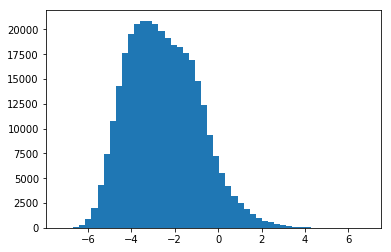

In [48]:
_ = plt.hist(np.log(predictions_train[:,0]/predictions_train[:,1]), 50)

# Validation

In [52]:
model.load_weights('last_epoch.hdf5')
predictions = model.predict(X_valid_sqr, verbose=1)
roc_auc_score(y_valid_cat, predictions)

40000/40000 [==============================] - 1s 14us/step


0.8691044805752655

In [53]:
model.load_weights('best.hdf5')
predictions = model.predict(X_valid_sqr, verbose=1)
roc_auc_score(y_valid_cat, predictions)

40000/40000 [==============================] - 1s 14us/step


0.8688193258969767

# Modelo todo el dataset

In [2]:
df = pd.read_csv('train.csv')

In [3]:
X = df.drop(columns=['ID_code', 'target']).values
y = df['target'].values

In [5]:
%time X_aug, y_aug = augment(X, y)

CPU times: user 4.62 s, sys: 495 ms, total: 5.11 s
Wall time: 1.56 s


In [13]:
y_aug_cat = np.array([y_aug, 1-y_aug]).T

In [7]:
model = Sequential()
p_do = 0.5
model.add(Dense(200, input_shape=(X_aug.shape[1],))) #kernel_regularizer=l1_reg,
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p_do))

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p_do))

# model.add(Dense(200))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(p_do))

model.add(Dense(2, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
__________

In [8]:
batch_size = 256
optimizer = adam(lr=1e-4)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(X_aug, y_aug_cat, 
          batch_size=batch_size, 
          epochs=20, 
#          callbacks = [checkpoint],
          verbose=1) 
          #class_weight=class_weight_keras)

Epoch 1/20
420098/420098 [==============================] - 5s 12us/step - loss: 0.4779 - acc: 0.8195
Epoch 2/20
420098/420098 [==============================] - 4s 10us/step - loss: 0.3679 - acc: 0.8568
Epoch 3/20
420098/420098 [==============================] - 5s 11us/step - loss: 0.3363 - acc: 0.8674
Epoch 4/20
420098/420098 [==============================] - 5s 11us/step - loss: 0.3225 - acc: 0.8719
Epoch 5/20
420098/420098 [==============================] - 4s 11us/step - loss: 0.3145 - acc: 0.8748
Epoch 6/20
420098/420098 [==============================] - 4s 11us/step - loss: 0.3101 - acc: 0.8761
Epoch 7/20
420098/420098 [==============================] - 5s 12us/step - loss: 0.3065 - acc: 0.8777
Epoch 8/20
420098/420098 [==============================] - 5s 12us/step - loss: 0.3036 - acc: 0.8788
Epoch 9/20
420098/420098 [==============================] - 4s 11us/step - loss: 0.3008 - acc: 0.8794
Epoch 10/20
420098/420098 [==============================] - 4s 11us/step - loss: 

In [15]:
model.save('MLP_keras_all_data.h5')

# Test

In [105]:
df_test = pd.read_csv('test.csv').set_index('ID_code')

In [54]:
test_predictions = model.predict(df_test.values, verbose=1)

200000/200000 [==============================] - 3s 14us/step


In [55]:
df_test['target'] = test_predictions[:,0]

In [56]:
filename = 'submission_{}.csv'.format(auc_score)
df_test[['target']].to_csv(filename)

In [58]:
! ls

before_best.hdf5	   submission_0.8615885372698715.csv
best.hdf5		   submission_0.8639528713193811.csv
best_orig.hdf5		   submission_0.864849032756072.csv
clr.py			   test.csv
data			   test.csv.zip
__pycache__		   train.csv
sample_submission.csv.zip  train.csv.zip
santander_MLP.ipynb


In [36]:
# ! kaggle competitions submit -c santander-customer-transaction-prediction -f {filename} -m "Second submit"

100%|███████████████████████████████████████| 4.34M/4.34M [00:06<00:00, 751kB/s]
Successfully submitted to Santander Customer Transaction Prediction